In [ ]:
from media_processing.data_processor import DataProcessor, DataLoader

# Torch imports
from model import *
import torch.optim as optim
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch

# Libs imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import pandas as pd
import time

cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [99]:
IMAGE_SIZE = 96

dp = DataProcessor()
dp.load_dataset(width=IMAGE_SIZE, height=IMAGE_SIZE)

Processing Videos: 100%|██████████| 60/60 [22:46<00:00, 22.78s/video]


In [102]:
video_train, video_val = dp.train_test_datasets(train_size=0.9, shuffle=True)
train_dataloader = DataLoader(data=video_train)
val_dataloader = DataLoader(data=video_val)

In [103]:
print('Train dataset size:', len(train_dataloader))
print('Validation dataset size:', len(val_dataloader))

Train dataset size: 54
Validation dataset size: 6


In [104]:
length_video = []

for _, video, _ in train_dataloader:
    length_video.append(video.shape[0])

for _, video, _ in val_dataloader:
    length_video.append(video.shape[0])

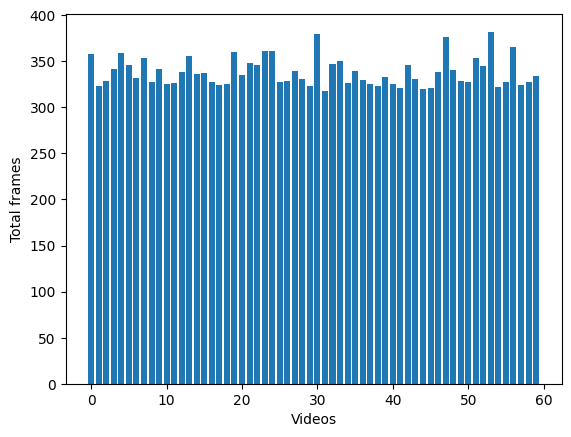

In [105]:
plt.bar(range(len(length_video)), length_video)
plt.ylabel('Total frames')
plt.xlabel('Videos')
plt.show()

In [106]:
print('Total Sum of Frames: ', sum(length_video))

Total Sum of Frames:  20289


In [107]:
for marker, video, audio in train_dataloader:
    print('Labels shape: ', marker.shape)
    print('Video shape: ', video.shape)
    print('Audio shape: ', audio.shape)
    break

Labels shape:  torch.Size([323, 1])
Video shape:  torch.Size([323, 3, 96, 96])
Audio shape:  torch.Size([323, 1])


In [108]:
def metric(output, target):
    pred = (output > 0.5).float()
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_item(loss_func, output, target, optimizer=None):
    loss_value = loss_func(output, target)

    metric_value = metric(output, target)

    if optimizer is not None:
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    
    return loss_value.item(), metric_value / target.shape[0]

def loss_epoch(model, loss_func, data_loader, device, optimizer=None):

    running_loss = 0.0
    running_metric = 0.0
    
    for markers, video, audio in tqdm(data_loader, desc='Predicting Videos', unit='video', disable=True):
        video, audio, markers = video.to(device), audio.to(device), markers.to(device)
        model_output = model(video, audio)

        loss_value, metric_value = loss_item(loss_func, model_output, markers, optimizer)

        running_loss += loss_value
        running_metric += metric_value
            
    average_loss = running_loss / len(data_loader)
    average_metric = running_metric / len(data_loader)

    return average_loss, average_metric

In [ ]:
def save_model(model, name):
    model_dir = os.path.join(os.getcwd(), 'data', 'models')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    os.makedirs(model_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_dir, f'{name}.pth'))

def load_model(model, name):
    model_dir = os.path.join(os.getcwd(), 'data', 'models')
    model = model.__class__()
    model.load_state_dict(torch.load(os.path.join(model_dir, f'{name}.pth'), weights_only=True))
    return model

In [110]:
def train_val(model, params, device, name, verbose=True):
    epochs = params['epochs']
    loss_func = params['loss_func']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    lr_scheduler = params['lr_scheduler']
    patience = params['patience']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}
    best_loss = float('inf')
    epoch_since_improvement = 0

    for epoch in range(epochs):
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, device, optimizer)

        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, device)
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        if train_loss < best_loss:
            best_loss = train_loss
            epoch_since_improvement = 0
            save_model(model, name=name)
        else:
            epoch_since_improvement += 1

        if patience < epoch_since_improvement:
            print(f'Early stopping')
            break
        
        lr_scheduler.step()
        if verbose and epoch % 5 == 0:
            print(f'Epoch {epoch + 1}/{epochs}: train loss: {train_loss:.6f}, train accuracy: {train_metric:.2f} \nvalidation loss: {val_loss:.6f}, validation accuracy: {val_metric:.2f}')
            print()

    model = load_model(model, name)

    return model, loss_history, metric_history

In [111]:
num_models_to_train = 4

model_names = ['Net_MN_Small_Lite', 'Net_MN_Small', 'Net_MN_Large', 'Net_EN_B0'][:num_models_to_train]
models = [Net_MN_Small_Lite(), Net_MN_Small(), Net_MN_Large(), Net_EN_B0()][:num_models_to_train]

models_train_loss = {}
models_val_loss = {}

models_train_acc = {}
models_val_acc = {}

In [112]:
device = torch.device('cuda:0')

for model, name in zip(models, model_names):
    learning_rate = 3e-4 
    model = model.to(device)
    loss_func = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    params = {
        'epochs': 10,
        'optimizer': optimizer,
        'loss_func': loss_func,
        'train_dl': train_dataloader,
        'val_dl': val_dataloader,
        'lr_scheduler': lr_scheduler,
        'patience': 5
    }

    start_time = time.perf_counter()
    model_trained, loss_history, metric_history = train_val(model, params, device, name, verbose=False)
    end_time = time.perf_counter()

    models_train_loss[name] = loss_history['train']
    models_val_loss[name] = loss_history['val']

    models_train_acc[name] = metric_history['train']
    models_val_acc[name] = metric_history['val']
    
    print(f'Model {name} trained with time: {end_time - start_time:.2f} sec')

Model Net_MN_Small_Lite trained with time: 158.08 sec
Model Net_MN_Small trained with time: 132.46 sec
Model Net_MN_Large trained with time: 258.60 sec
Model Net_EN_B0 trained with time: 928.22 sec


In [113]:
models_trained = [load_model(model, name) for model, name in zip(models, model_names)]

In [ ]:
def dict_to_dataframe(data, metric_name):
    df = pd.DataFrame(data)
    df = df.melt(var_name='Model', value_name=metric_name, ignore_index=False)
    df = df.reset_index().rename(columns={'index': 'Epoch'})
    df['Epoch'] += 1
    return df

metrics = ['Train Loss', 'Validation Loss', 'Train accuracy', 'Validation accuracy']

df_train_loss = dict_to_dataframe(models_train_loss, metrics[0])
df_val_loss = dict_to_dataframe(models_val_loss, metrics[1])
df_train_acc = dict_to_dataframe(models_train_acc, metrics[2])
df_val_acc = dict_to_dataframe(models_val_acc, metrics[3])

total_data = [df_train_loss, df_val_loss, df_train_acc, df_val_acc]

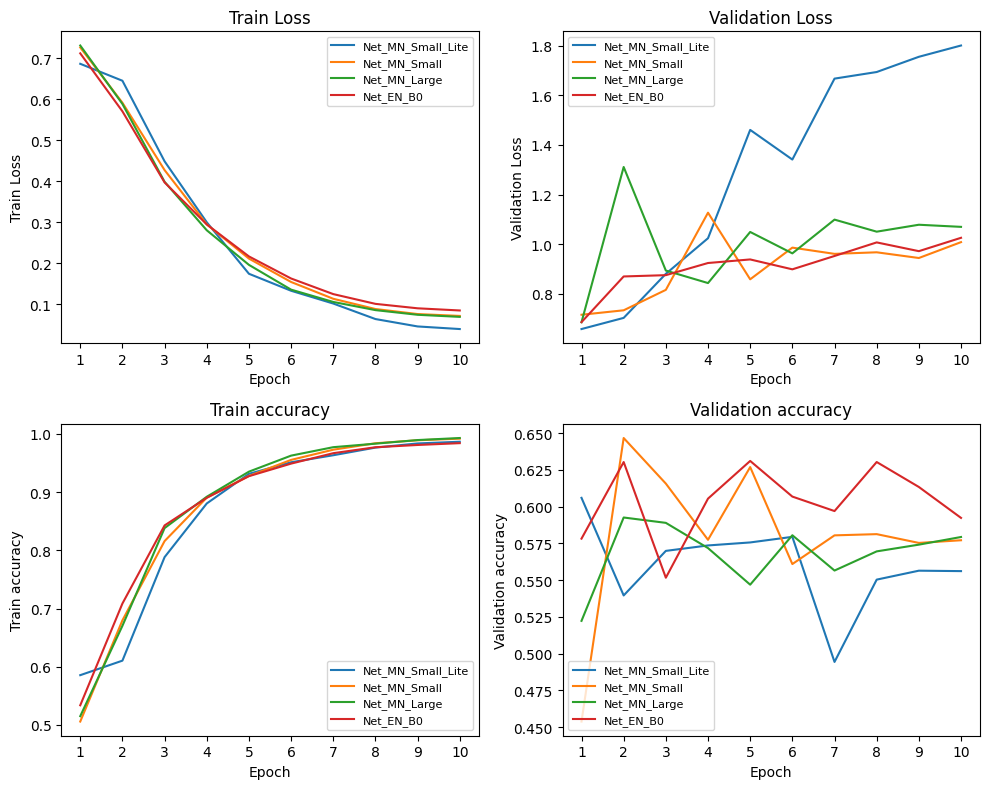

In [119]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        sns.lineplot(data=total_data[index], x='Epoch', y=metrics[index], hue='Model', ax=ax[row, col])
        ax[row, col].set_title(metrics[index])
        ax[row, col].set_xticks(range(1, params['epochs'] + 1))
        ax[row, col].legend(prop={'size': 8})
    plt.tight_layout()

plt.tight_layout()
plt.show()

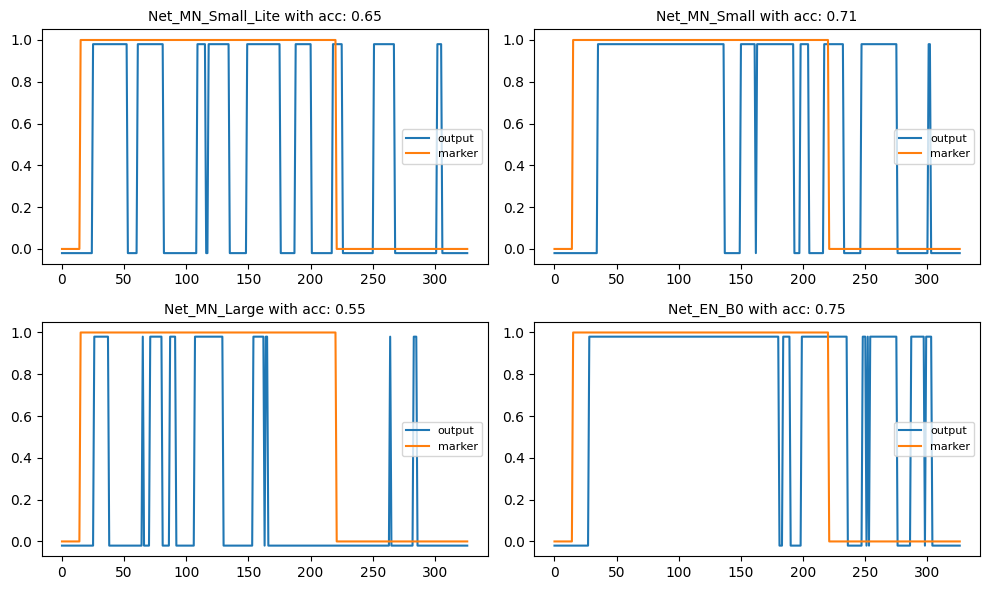

In [120]:
def prediction_models(data):
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    axes = ax.ravel()

    for i, (model_name, data) in enumerate(data.items()):
        df = pd.DataFrame({
            'output': data['output'].flatten() - 0.02,
            'marker': data['marker'].flatten(),
        })

        sns.lineplot(data=df, ax=axes[i], dashes=False)
        accuracy = (data['marker'] == data['output']).sum() / data['marker'].shape[0]
        axes[i].set_title(f'{model_name} with acc: {accuracy:.2f}', fontsize=10)
        axes[i].legend(loc=5, prop={'size': 8})

    plt.tight_layout()

output_labels = {}

for marker, video, audio in val_dataloader:
    marker = marker.cpu().numpy()   
    for model, name in zip(models_trained, model_names):
        model.eval()
        with torch.no_grad():
            output = (model(video, audio) > 0.5).float().cpu().numpy()
        output_labels[name] = {
            'output': output,
            'marker': marker
        }
    break

prediction_models(output_labels)

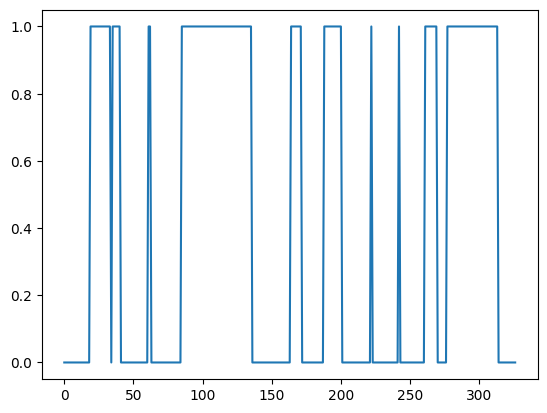

In [128]:
def merge_predictions(models, video, audio):
    video, audio = video.to(device), audio.to(device)

    all_predictions = []
    for model in models:
        model = model.to(device)
        pred = (model(video, audio) > 0.5).float().cpu().numpy()
        all_predictions.append(pred)
    all_predictions = np.array(all_predictions).reshape(len(models), -1)

    return np.where(np.count_nonzero(all_predictions == 1, axis=0) > 2, 1, 0)

for marker, video, audio in val_dataloader:
    merge_output = merge_predictions(models_trained, video, audio)
    break

plt.plot(range(len(merge_output)), merge_output)

In [ ]:
# from predictions import VideoTrimmer

In [ ]:
# 0uOkigs9hnY

# video_folder = os.path.join(os.getcwd(), 'data', 'videos')
# output_folder = os.path.join(os.getcwd(), 'data', 'trimmed')
# model_name = '1.47val_loss_23_train_10_epoch'

# trimmer = VideoTrimmer(video_folder, output_folder, models, model_names)    
# trimmer.predict_trimmed('0uOkigs9hnY', 4, rec_clip_duration=10)
# trimmer.predict_trimmed('nikita', 4)